Job creation condition
$$
    R = 1 - \frac{c \: (r+ \lambda)}{q(\theta)(1-\eta)}
$$

Job destruction condition
$$
    R + \frac{\lambda}{r+\lambda} \int_R^1(z-R) \: dG(z) = \frac{b}{p}+\frac{\eta}{1-\eta} \; c \theta
$$

Steady state unemployment is given by:
$$
   u = \frac{\lambda G(R)}{\lambda G(R) + \theta q(\theta)}
$$

## The Integral

The integral you're trying to solve is:

$$\int_R^1 (z-R) \, dG(z)$$

where G(z) is the CDF of your truncated lognormal distribution.

## Issue

The truncation of the lognormal distribution between 0 and 1 complicates the analytical solution. An analytical solution is preferable because it is faster.


## Solution

Express the integral in terms of normal CDF Φ

1. Rewrite G(z) in terms of the standard normal CDF Φ:

   $$G(z) = \frac{\Phi(\frac{\ln z - \mu}{\sigma}) - \Phi(\frac{\ln 0 - \mu}{\sigma})}{\Phi(\frac{\ln 1 - \mu}{\sigma}) - \Phi(\frac{\ln 0 - \mu}{\sigma})}$$

2. Now, we can rewrite the integral:

   $$\int_R^1 (z-R) \, dG(z) = \int_R^1 z \, dG(z) - R[G(1) - G(R)]$$

3. The first term can be expressed as:

   $$\int_R^1 z \, dG(z) = \frac{\int_R^1 z \, d\Phi(\frac{\ln z - \mu}{\sigma})}{\Phi(\frac{-\mu}{\sigma}) - \Phi(\frac{-\infty}{\sigma})}$$

4. This can be further simplified using the properties of the lognormal distribution:

   $$\frac{\exp(\mu + \frac{\sigma^2}{2})[\Phi(\frac{\ln 1 - \mu - \sigma^2}{\sigma}) - \Phi(\frac{\ln R - \mu - \sigma^2}{\sigma})]}{\Phi(\frac{-\mu}{\sigma}) - \Phi(-\infty)}$$

## Final Expression

Combining these steps, we get:

$$\frac{\exp(\mu + \frac{\sigma^2}{2})[\Phi(\frac{-\mu - \sigma^2}{\sigma}) - \Phi(\frac{\ln R - \mu - \sigma^2}{\sigma})]}{\Phi(\frac{-\mu}{\sigma}) - \Phi(-\infty)} - R[\frac{\Phi(\frac{-\mu}{\sigma}) - \Phi(\frac{\ln R - \mu}{\sigma})}{\Phi(\frac{-\mu}{\sigma}) - \Phi(-\infty)}]$$

While this expression doesn't provide a simple closed-form solution, it reduces the problem to evaluations of the standard normal CDF Φ, which is a well-tabulated function and can be computed efficiently.

In [1]:
using Distributions, NLsolve, QuadGK, PrettyTables, Plots, Statistics

In [2]:
# Function to solve the job market model: System of 2 equations JD and JC
function job_market!(F, vars, p, w_bar, α, σ, r, λ, c, b, η)
    R, θ = vars  # R and θ are the variables to solve for
    
    # Frequency of job offers
    q = θ^(-α)
    
    # Calculate the expected surplus above R
    μ = log(w_bar)
    Φ_R = (cdf(Normal(μ, σ), log(R)) - cdf(Normal(μ, σ), log(10e-6))) / 
          (cdf(Normal(μ, σ), log(1.0)) - cdf(Normal(μ, σ), log(10e-6)))
    Φ_1 = (cdf(Normal(μ, σ), log(1.0)) - cdf(Normal(μ, σ), log(10e-6))) / 
          (cdf(Normal(μ, σ), log(1.0)) - cdf(Normal(μ, σ), log(10e-6)))

    # Compute shifted terms for expected value calculation
    exp_mean_shifted = exp(μ + σ^2 / 2)
    Φ_R_shifted = (cdf(Normal(μ, σ), log(R) - σ^2) - cdf(Normal(μ, σ), log(10e-6))) / 
                  (cdf(Normal(μ, σ), log(1.0)) - cdf(Normal(μ, σ), log(10e-6)))

    expected_surplus_above_R = (exp_mean_shifted * (Φ_1 - Φ_R_shifted)) / Φ_1 - R * (Φ_1 - Φ_R) / Φ_1
    
    # Job Creation Condition
    F[1] = R - (1 - c * (r + λ) / (q * (1 - η)))

    # Job Destruction Condition
    F[2] = R + (λ / (r + λ)) * expected_surplus_above_R - (b / p + η / (1 - η) * c * θ)
end

# Wrapper function to solve for R and θ with clear use of 'p'
function solve_job_market(p, w_bar, α, σ, r, λ, c, b, η; initial_guess=[0.5, 0.5])
    # Define a closure that only takes vars as input, with other parameters fixed
    function f!(F, vars)
        job_market!(F, vars, p, w_bar, α, σ, r, λ, c, b, η)
    end
    
    # Use NLsolve to find the root
    result = nlsolve(f!, initial_guess)

    # Check if the solver converged
    if result.f_converged
        return result.zero  # returns the solution for R and θ
    else
        error("Solver did not converge. Try a different initial guess or parameter set.")
    end
end


# Sample parameters (you can adjust these to test different scenarios)
p = 1.0         # productivity
α = 0.5         # elasticity parameter for q(θ)
w_bar = 0.3     # expected value of wage distributiom
σ = 0.5         # standard deviation of wage distribution
r = 0.05        # discount rate
λ = 0.2         # job separation rate
c = 0.1         # job creation cost
b = 0.1         # unemployment benefits
η = 0.2         # bargaining power of workers
x = 1.0         # idiosyncratic productivity
# Solve for R and θ with specified parameters
solution = solve_job_market(p, w_bar, α, σ, r, λ, c, b, η)
println("Solution for R and θ:")
println("R = ", solution[1])
println("θ = ", solution[2])


Solution for R and θ:
R = 0.8303688156028137
θ = 29.46533244876296


In [3]:
# Function to solve the job market model: System of 2 equations JD and JC
function job_market_numerical!(F, vars, p, w_bar, α, σ, r, λ, c, b, η)
    R, θ = vars  # R and θ are the variables to solve for
    
    # Frequency of job offers
    q = θ^(-α)

    # Job Creation Condition
    F[1] = R - (1 - c * (r + λ) / (q * (1 - η)))

    # Job Destruction Condition
    μ = log(w_bar)
    g(x) = pdf(Normal(μ, σ), log(x)) / 
    (cdf(Normal(μ, σ), log(1.0)) - cdf(Normal(μ, σ), log(10e-6)))

    # Integrate (x - R) * g(x) over [R, 1]
    expected_surplus_above_R, _ = quadgk(x -> (x - R) * g(x), R, 1)


    # Full job destruction equation
    F[2] = R + (λ / (r + λ)) * expected_surplus_above_R - (b / p + η / (1 - η) * c * θ)
end

# Wrapper function to solve for R and θ with clear use of 'p'
function solve_job_market_numerical(p, w_bar, α, σ, r, λ, c, b, η; initial_guess=[0.5, 0.5])
    # Define a closure that only takes vars as input, with other parameters fixed
    function f!(F, vars)
        job_market_numerical!(F, vars, p, w_bar, α, σ, r, λ, c, b, η)
    end
    
    # Use NLsolve to find the root
    result = nlsolve(f!, initial_guess)

    # Check if the solver converged
    if result.f_converged
        return result.zero  # returns the solution for R and θ
    else
        error("Solver did not converge. Try a different initial guess or parameter set.")
    end
end

# Sample parameters (you can adjust these to test different scenarios)
p = 1.0         # productivity
α = 0.5         # elasticity parameter for q(θ)
w_bar = 0.3     # expected value of wage distribution
σ = 1         # standard deviation of wage distribution
r = 0.05        # discount rate
λ = 0.2         # job separation rate
c = 0.1         # job creation cost
b = 0.1         # unemployment benefits
η = 0.2         # bargaining power of workers
x = 1.0         # idiosyncratic productivity

# Solve for R and θ with specified parameters using numerical integration
solution_numerical = solve_job_market_numerical(p, w_bar, α, σ, r, λ, c, b, η)
println("Solution for R and θ:")
println("R = ", solution_numerical[1])
println("θ = ", solution_numerical[2])

Solution for R and θ:
R = 0.830739219165492
θ = 29.33679301465507


In [16]:
# Function to calculate expected surplus above R analytically
function expected_surplus_analytical(R, w_bar, σ)
    μ = log(w_bar)
    Φ_R = (cdf(Normal(μ, σ), log(R)) - cdf(Normal(μ, σ), log(10e-6))) / 
          (cdf(Normal(μ, σ), log(1.0)) - cdf(Normal(μ, σ), log(10e-6)))
    Φ_1 = (cdf(Normal(μ, σ), log(1.0)) - cdf(Normal(μ, σ), log(10e-6))) / 
          (cdf(Normal(μ, σ), log(1.0)) - cdf(Normal(μ, σ), log(10e-6)))

    # Compute shifted terms for expected value calculation
    exp_mean_shifted = exp(μ + σ^2 / 2)
    Φ_R_shifted = (cdf(Normal(μ, σ), log(R) - σ^2) - cdf(Normal(μ, σ), log(10e-6))) / 
                  (cdf(Normal(μ, σ), log(1.0)) - cdf(Normal(μ, σ), log(10e-6)))

    return (exp_mean_shifted * (Φ_1 - Φ_R_shifted)) / Φ_1 - R * (Φ_1 - Φ_R) / Φ_1
end


# Function to calculate expected surplus above R numerically
function expected_surplus_numerical(R,w_bar, σ)
    μ = log(w_bar)
    # Normalized PDF
    g(x) = pdf(Normal(μ, σ), log(x)) / 
           (cdf(Normal(μ, σ), log(1.0)) - cdf(Normal(μ, σ), log(10e-6)))

    # Integrate (x - R) * g(x) over [R, 1]
    result, _ = quadgk(x -> (x - R) * g(x), R, 1)
    return result
end

# Parameters
w_bar = 0.3
σ = 0.5

# R values to test
R_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Number of iterations for timing
n_iterations = 1000

# Timing function
function time_function(f, args...)
    times = Float64[]
    for _ in 1:n_iterations
        t = @elapsed f(args...)
        push!(times, t)
    end
    return mean(times)
end

function memory_function(f, args...)
    mems = Int64[]
    for _ in 1:n_iterations
        m = @allocated f(args...)
        push!(mems, m)
    end
    return mean(mems)
end


# Create a data structure to hold the results
results = []

for R in R_values
    analytical = expected_surplus_analytical(R, w_bar, σ)
    numerical = expected_surplus_numerical(R, w_bar, σ)
    difference = abs(analytical - numerical)

    
    analytical_time = time_function(expected_surplus_analytical, R, w_bar, σ)
    numerical_time = time_function(expected_surplus_numerical, R, w_bar, σ)

    analytical_memory = memory_function(expected_surplus_analytical, R, w_bar, σ)
    numerical_memory = memory_function(expected_surplus_numerical, R, w_bar, σ)
    
    push!(results, (R, analytical, numerical, difference, analytical_time, numerical_time, analytical_memory, numerical_memory))
end

# Print the table
println("Comparison of expected_surplus_above_R:")
println("┌────────┬─────────────┬─────────────┬─────────────┬────────────────┬────────────────┬─────────────────┬─────────────────┐")
println("│   R    │ Analytical  │  Numerical  │ Difference  │ Analytical Time│ Numerical Time │    Analytical   │     Numerical   │")
println("│        │             │             │             │      (s)       │      (s)       │      Memory     │      Memory     │")
println("├────────┼─────────────┼─────────────┼─────────────┼────────────────┼────────────────┤─────────────────┤─────────────────┤")

for result in results
    println("│ $(lpad(string(result[1]), 6)) │ $(lpad(string(round(result[2], digits=6)), 11)) │ $(lpad(string(round(result[3], digits=6)), 11)) │ $(lpad(string(round(result[4], digits=8)), 11)) │ $(lpad(string(round(result[5], digits=8)), 14)) │ $(lpad(string(round(result[6], digits=8)), 14)) │ $(lpad(string(round(result[7], digits=0)), 15)) │ $(lpad(string(round(result[8], digits=0)), 15)) │")
end

println("└────────┴─────────────┴─────────────┴─────────────┴────────────────┴────────────────┴─────────────────┴─────────────────┘")

# Overall timing comparison
total_analytical_time = @elapsed for _ in 1:n_iterations, R in R_values
    expected_surplus_analytical(R, w_bar, σ)
end

total_numerical_time = @elapsed for _ in 1:n_iterations, R in R_values
    expected_surplus_numerical(R, w_bar, σ)
end

println("\nTotal time for $n_iterations iterations over all R values:")
println("Analytical method: $(round(total_analytical_time, digits=6)) seconds")
println("Numerical method: $(round(total_numerical_time, digits=6)) seconds")
println("Ratio (Numerical/Analytical): $(round(total_numerical_time/total_analytical_time, digits=2))")

Comparison of expected_surplus_above_R:
┌────────┬─────────────┬─────────────┬─────────────┬────────────────┬────────────────┬─────────────────┬─────────────────┐
│   R    │ Analytical  │  Numerical  │ Difference  │ Analytical Time│ Numerical Time │    Analytical   │     Numerical   │
│        │             │             │             │      (s)       │      (s)       │      Memory     │      Memory     │
├────────┼─────────────┼─────────────┼─────────────┼────────────────┼────────────────┤─────────────────┤─────────────────┤
│    0.1 │    0.240158 │    0.104395 │  0.13576319 │         4.0e-7 │        5.99e-6 │            16.0 │           384.0 │
│    0.2 │    0.149487 │    0.072336 │  0.07715096 │         3.6e-7 │        5.86e-6 │            16.0 │           384.0 │
│    0.3 │    0.085424 │    0.045761 │   0.0396631 │         3.5e-7 │        3.65e-6 │            16.0 │           384.0 │
│    0.4 │    0.047616 │    0.026933 │  0.02068314 │         3.4e-7 │        3.53e-6 │            1

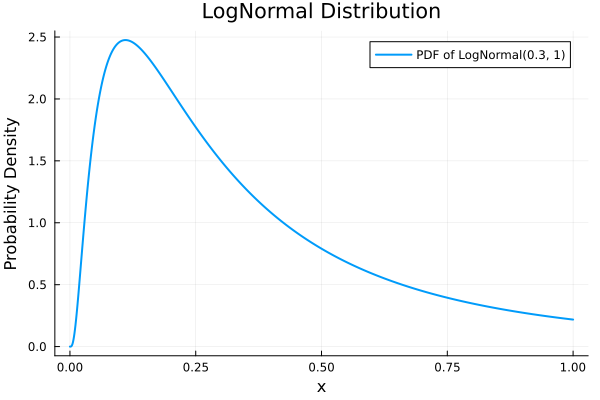

In [ ]:
# Wage distribution
μ_for_mean(w_bar, σ) = log(w_bar) - σ^2/2

g = Truncated(LogNormal(μ_for_mean(w_bar, σ), σ), 0, 1)
x_axis = range(0, 1, length=1000)

# Plot the PDF
plot(x_axis, pdf.(g, x_axis), 
     label="PDF of LogNormal($(w_bar), $(σ))",
     title="LogNormal Distribution",
     xlabel="x",
     ylabel="Probability Density",
     linewidth=2,
     legend=:topright)

In [18]:
cdf(g, 0.75)

0.9852281668488264

In [19]:
G_R = cdf(Truncated(LogNormal(w_bar, σ), 0, 1), solution[1])

0.6037573376769202

In [20]:
w = (1-η) * b + η * p * ( x + c * solution[2]);
U = (b + (η/(1-η)) * p * c * solution[2])/r

16.73266622438148

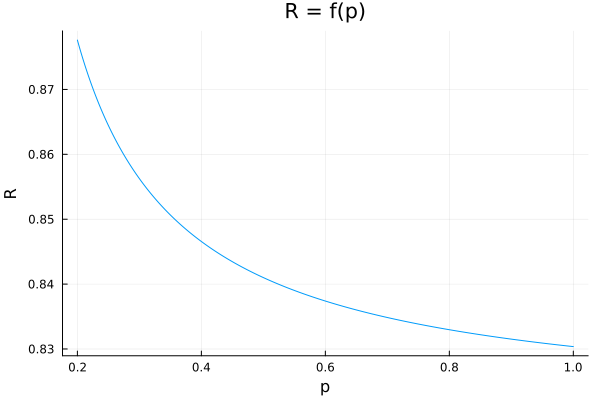

In [21]:
# Grid search over p
p_values = range(0.2, 1, length=1000)
R_values = Float64[]
θ_values = Float64[]
U_values = Float64[]

for p in p_values
    try
        solution = solve_job_market(p, w_bar, α, σ, r, λ, c, b, η)
        push!(R_values, solution[1])
        push!(θ_values, solution[2])
        U = (b + (η / (1 - η)) * p * c * solution[2]) / r
        push!(U_values, U)
    catch
        # If solver doesn't converge, we'll skip this point
        push!(R_values, NaN)
        push!(θ_values, NaN)
        push!(U_values, NaN)
    end
end

# Plotting
plot(p_values, R_values, label="R", title="R = f(p)", xlabel="p", ylabel="R", legend = false)

In [22]:
p_values

0.2:0.0008008008008008008:1.0

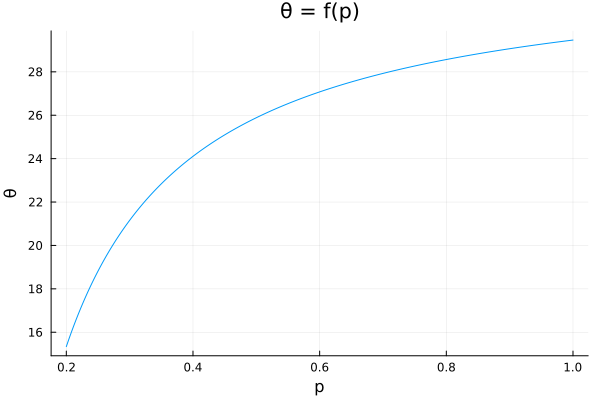

In [23]:
plot(p_values, θ_values, label="θ", title="θ = f(p)", xlabel="p", ylabel="θ", legend = false)

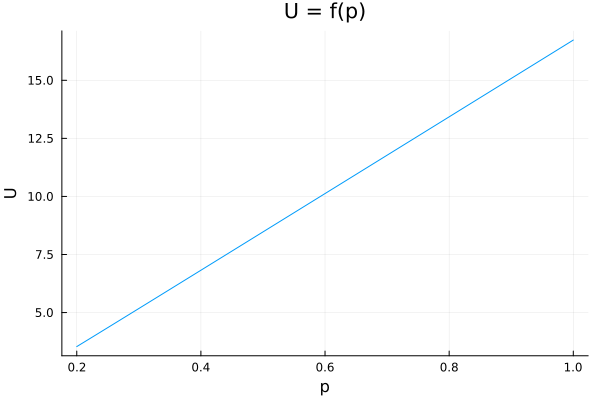

In [24]:
plot(p_values, U_values, label="U", title="U = f(p)", xlabel="p", ylabel="U", legend = false)